### Objective: Comparison of well-based and seismic acoustic impedance
Check for issues related to sampling bias by using the acoustic impedance data collected at the wells and comparing it to the seismic acoustic impedence which covers the entire site area.

In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python
from scipy import stats                   # for employing statistical tests

Reading in both the raw and the cleaned data.

In [2]:
df_raw = pd.read_csv('1_sample_data.csv')
seismic = np.loadtxt('1_AI.csv',delimiter=',')
shale_clean = pd.read_csv('Shale_cleaned.csv')
sand_clean = pd.read_csv('Sandstone_cleaned.csv')

Combining the outlier cleaned dataframes to put both facies back together in a single dataframe. Removing unnecessary columns that are unnamed.

In [3]:
df_clean = pd.concat([shale_clean, sand_clean], axis=0)
del df_clean['Unnamed: 0']
del df_clean['Unnamed: 0.1']

Checking the first few rows of the combined dataframe and then checking the basic descriptive statistics.

In [4]:
df_clean.head()

,X,Y,Facies,Porosity,Perm,AI
0,80.0,280.0,0.0,0.102919,0.196018,6753.323723
1,160.0,840.0,0.0,0.128852,0.673043,6068.296567
2,160.0,760.0,0.0,0.103365,5.368073,5574.433666
3,160.0,120.0,0.0,0.142252,5.189214,7330.542384
4,320.0,120.0,0.0,0.135132,1.850340,5501.993421


In [5]:
df_clean.describe()

,X,Y,Facies,Porosity,Perm,AI
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,499.239631,511.829493,0.755760,0.135367,18.035989,5345.280866
std,289.087802,278.041819,0.430629,0.024090,31.580576,1015.398810
min,0.000000,9.000000,0.000000,0.060693,0.018054,3017.611167
25%,240.000000,280.000000,1.000000,0.117816,0.991764,4636.958847
50%,490.000000,519.000000,1.000000,0.137027,4.903753,5352.280145
75%,740.000000,749.000000,1.000000,0.151227,15.704735,6155.298167
max,990.000000,1014.000000,1.000000,0.204388,193.746824,7911.757046


Comparing the histogram of acoustic impedence before and after data outliers were removed. 

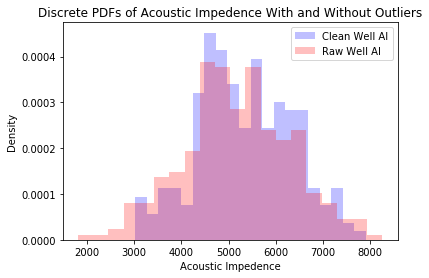

In [6]:
# comparing histograms of well AI with and without outliers
n_bins = 20

fig, ax1 = plt.subplots()
ax1.hist(df_clean['AI'], bins=n_bins, density=True, alpha=0.25, color='b', label='Clean Well AI')
ax1.hist(df_raw['AI'], bins=n_bins, density=True, alpha=0.25, color='r', label='Raw Well AI')
ax1.set_title('Discrete PDFs of Acoustic Impedence With and Without Outliers')
ax1.set_ylabel('Density')
ax1.set_xlabel('Acoustic Impedence')
ax1.legend()

plt.show()

Plotting histograms (normalized to be discrete PDFs) of the acoustic impedance data taken at wells with the seismic field of acoustic data. This allows us to compare the shapes of these discrete PDFs. 

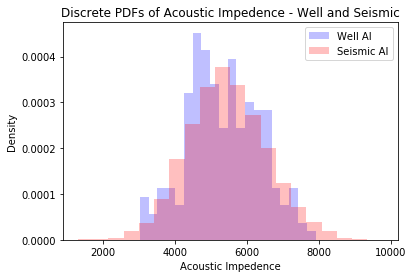

In [7]:
# comparing histograms of well AI with field of AI
n_bins = 20

fig, ax1 = plt.subplots()
ax1.hist(df_clean['AI'], bins=n_bins, density=True, alpha=0.25, color='b', label='Well AI')
ax1.hist(seismic.flatten(), bins=n_bins, density=True, alpha=0.25, color='r', label='Seismic AI')
ax1.set_title('Discrete PDFs of Acoustic Impedence - Well and Seismic')
ax1.set_ylabel('Density')
ax1.set_xlabel('Acoustic Impedence')
ax1.legend()

plt.show()

In [8]:
print('Average acoustic impedance from well data: ' + str(round(df_clean['AI'].values.mean(),1)))
print('Average acoustic impedance from seismic: ' + str(seismic.mean()))
print()
print('Median acoustic impedance from well data: ' + str(round(np.median(df_clean['AI'].values),1)))
print('Median acoustic impedance from seismic: ' + str(round(np.median(seismic),1)))
print()
print('Variance in acoustic impedance from well data: ' + str(round(np.var(df_clean['AI'].values),1)))
print('Variance acoustic impedance from seismic: ' + str(round(np.var(seismic),1)))

Average acoustic impedance from well data: 5345.3
Average acoustic impedance from seismic: 5444.0

Median acoustic impedance from well data: 5352.3
Median acoustic impedance from seismic: 5402.8

Variance in acoustic impedance from well data: 1026283.4
Variance acoustic impedance from seismic: 1185485.4


## Hypothesis Testing

Use the scipy stats package to perform a 2 sample t-test to test the null hypothesis that the mean of the acoustic impedance sampled from the wells ($\mu_{{AI}_{wells}}$) is equal to the mean acoustic impedance collected from the seismic data ($\mu_{{AI}_{seis}}$). 

$H_0: \mu_{{AI}_{wells}} = \mu_{{AI}_{seis}}$

$H_A: \mu_{{AI}_{wells}} \neq \mu_{{AI}_{seis}}$

The p-value returned by this test is approximately $p = 0.1859$. Therefore at a 5% confidence level ($\alpha = 0.05$) we cannot reject the null hypothesis, and we would say that the two sets of data share the same average.


In [9]:
stats.ttest_ind(df_clean['AI'],seismic.flatten())

Ttest_indResult(statistic=-1.323119677764624, pvalue=0.18582519710534606)

Performing a Rank-Sum test on the acoustic impedance samples to check if the measurements are taken from the same distribution. The Rank-Sum test returned a p-value of 0.2075, suggesting that at a 5% confidence level the null hypothesis that the distributions are equal cannot be rejected. This test further confirms the results from the 2 sample t-test. The Rank-Sum test might be thought of as the non-parametric analog to the t-test (i.e. it does not assume a normally distributed population).

In [10]:
stats.ranksums(df_clean['AI'],seismic.flatten())

RanksumsResult(statistic=-1.2604127847913624, pvalue=0.20752049201858347)

We can further test the different sampling methods by employing techniques typically used to evaluate groups of data. The popular ANOVA tests the null hypothesis that the mean values for the datasets are equivalent, it is a parametric test which assumes that the samples are drawn from a normally distributed population. The resulting p-value from our ANOVA test was 0.1858, and therefore the null is not rejected. Similarly, the Kruskal-Wallace test is the non-parametric analog to the ANOVA, and tests the null hypothesis that the population medians are equal. The p-value obtained via the Kruskal-Wallace test is 0.2075 and so the null is not rejected in this test either.

In [11]:
stats.f_oneway(df_clean['AI'],seismic.flatten())

F_onewayResult(statistic=1.7506456816879743, pvalue=0.1858251971043204)

In [12]:
stats.kruskal(df_clean['AI'],seismic.flatten())

KruskalResult(statistic=1.5886403894234302, pvalue=0.20752049182435714)